In [1]:
import pandas as pd
import numpy as np
import os
import json 
import sys
from typing import Dict, Tuple, Any, Optional, List
sys.path.append('..')
import time
from src.utils import load_data
from src.models import results_to_dict, get_score_and_re_eval, evaluate

c:\Users\1\anaconda3\envs\rag\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sys.path.append(r'C:\Users\1\Documents\GitHub\rageval')
from rageval.models import OpenAILLM

## human annotation

In [2]:
with open('../data/wikieval/human.json', 'r') as f:
    data = json.load(f)

In [4]:
data[0]['data']

{'context': 'Starship is a super heavy-lift launch vehicle under development by SpaceX. At 120 metres (394 feet) in height and with a liftoff mass of 5,000 metric tons (11,000,000 pounds), Starship is the largest and most powerful rocket ever flown, surpassing the thrust of NASA\'s Space Launch System and Saturn V, as well as the Soviet N1, which had previously held the record.The two-stage-to-orbit launch vehicle consists of the first-stage Super Heavy booster and the second-stage spacecraft also named Starship. Both stages are powered by Raptor rocket engines, which burn liquid methane and liquid oxygen, operating in a full-flow staged combustion power cycle. Both are designed to be fully reusable, performing controlled landings on the arms of the launch tower used to lift the vehicles and, eventually, reflown within hours. Starship is designed to have a payload capacity of 150 tonnes (330,000 lb) to low Earth orbit in a fully reusable configuration and 250 t (550,000 lb) when expend

In [10]:
def annotation_result_to_dict(data: List[Dict[str, Any]]) -> Dict[str, Any]:
    result = {}
    for d in data:
        if d['to_name'] == 'accuracy_text':
            result['Human Accuracy'] = int(d['value']['choices'][0])
        if d['to_name'] == 'informativeness_text':
            result['Human Informativeness'] = int(d['value']['choices'][0])
    return result

def get_human_scores(data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    results = []
    for d in data:
        result = d['data']
        result.update(annotation_result_to_dict(d['annotations'][0]['result']))
        results.append(result)
    return results

In [9]:
annotation_result_to_dict(data[0]['annotations'][0]['result'])

{'Human Accuracy': 5, 'Human Informativeness': 4}

In [12]:
dfh = pd.DataFrame(get_human_scores(data))

In [ ]:
df = load_data('../data/wikieval/3_evaluators.json')

In [25]:
df_filtered = df[(df['model'] != 'gpt-4o') & (df['model'] != 'claude-3.5') & (df['model'] != 'gemini-2.0')]
df_filtered = df_filtered.sort_values(['question', 'model'])

In [26]:
dfh = dfh.sort_values(['question', 'model'])

In [28]:
all(dfh['answer'].values == df_filtered['answer'].values)

True

In [29]:
df_filtered.columns

Index(['id', 'answer', 'context', 'question', 'model', 'gt_answer', 'dataset',
       'gpt', 'claude', 'gemini'],
      dtype='object')

In [30]:
df_filtered['Human Accuracy'] = dfh['Human Accuracy'].values
df_filtered['Human Informativeness'] = dfh['Human Informativeness'].values
df_filtered['Human'] = df_filtered['Human Accuracy'] + df_filtered['Human Informativeness']

In [34]:
df_filtered.to_json('../data/wikieval/350_human.json', orient='records', lines=True)

### rouge

In [36]:
answers = df_filtered['answer'].values
gt_answers = df_filtered['gt_answer'].values

In [42]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
score = scorer.score_multi([gt_answers[0]], answers[0])['rougeL'].fmeasure

In [44]:
scores = []
for i in range(len(answers)):
    score = scorer.score_multi([gt_answers[i]], answers[i])['rougeL'].fmeasure
    scores.append(score)

In [46]:
df_filtered['Rouge L'] = scores

### bertscore

In [48]:
from bert_score import BERTScorer
scorer = BERTScorer(lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
scores = []
for i in range(len(answers)):
    _, _, F1 = scorer.score([gt_answers[i]], [answers[i]])
    scores.append(F1.max().tolist())

In [54]:
df_filtered['Bert Score'] = scores

## prompt

In [1]:
FG_SYSTEM = """Score the following llm output of a question answering task with respect to following aspects with 1 to 5 stars.

Accuracy: determine the accuracy of the answers, verifying the correctness and reliability of the provided information.
1 star means Incorrect information 
2 stars means Partially correct information 
3 stars means half correct information
4 stars means Mostly correct information 
5 stars means Perfectly correct information

Informativeness: examines whether the answers provide sufficient and meaningful information that useful to the user and relevant to the question.
1 star means No information or irrelevant information
2 star means Very little information
3 stars means Some information
4 stars means Enough information
5 stars means Highly informative

Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please provide your evaluation by strictly following the JSON format such as: [[SCORE]] {"accuracy": 2, "informativeness": 3}.
"""

TASK_INSTRUCTION = """Score the following llm output of a question answering task with respect to following aspects with 1 to 5 stars."""
DATASET_INSTRUCTION = """The dataset consists of 350 questions and answers. Each question has been answered by 3 evaluators and the answers have been generated by 3 different language models. The dataset also includes the ground truth answers."""
OUTPUT_INSTRUCTION = """Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please provide your evaluation by strictly following the JSON format such as: [[SCORE]] {"accuracy": 2, "informativeness": 3}."""
ACC_INSTRUCTION = """Accuracy: determine the accuracy of the answers, verifying the correctness and reliability of the provided information.
1 star means Incorrect information 
2 stars means Partially correct information 
3 stars means half correct information
4 stars means Mostly correct information 
5 stars means Perfectly correct information"""
INF_INSTRUCTION = """Informativeness: examines whether the answers provide sufficient and meaningful information that useful to the user and relevant to the question.
1 star means No information or irrelevant information
2 star means Very little information
3 stars means Some information
4 stars means Enough information
5 stars means Highly informative"""

In [5]:
SHORT_INSTRUCTION = """Provide a brief, objective explanation, then rate the response from 1 to 10 using the format: Rating: [[X]].
"""

NORMAL_INSTRUCTION = """Please act as an impartial judge and evaluate the quality of the response provided by an AI assistant to the user question displayed below. Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, and level of detail of the response. Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please rate the response on a scale of 1 to 10 by strictly following this format: [[rating]], for example: Rating: [[5]].
"""

LONG_INSTRUCTION = """You are tasked with assuming the role of an impartial and objective evaluator, meticulously assessing the quality of the response generated by an AI assistant in direct relation to the user's query, which is explicitly outlined below. 

In conducting your evaluation, you are expected to consider a comprehensive array of factors, including but not limited to:

    - Helpfulness: The extent to which the response effectively addresses the user's question, providing clear, actionable, and useful information.
    - Relevance: The degree to which the response remains focused on the specific topic or issue raised by the user, avoiding tangential or unrelated content.
    - Accuracy: The factual correctness and reliability of the information provided in the response, ensuring that it aligns with established knowledge or evidence.
    - Depth: The level of insight, analysis, or elaboration offered in the response, demonstrating a thorough understanding of the subject matter.
    - Level of Detail: The amount of specific information, examples, or explanations included in the response, contributing to a richer and more informative answer.

Your evaluation should begin with a concise yet comprehensive explanation of your assessment, highlighting the strengths and weaknesses of the AI assistant's response in relation to the aforementioned criteria. It is imperative that you maintain an objective and unbiased stance throughout this process, avoiding any personal opinions or subjective judgments.

Upon completing your explanation, you are required to assign a numerical rating to the response, reflecting its overall quality. This rating must be provided on a scale ranging from 1 to 10, where 1 signifies a poor or inadequate response and 10 denotes an exceptional or outstanding one. The rating should be formatted strictly as follows: [[rating]], for example: Rating: [[5]].

Please ensure that your evaluation is thorough, well-reasoned, and adheres to the guidelines outlined above.
"""

QA = """[Question]
{question}

[The Start of Assistant’s Answer]
{answer}
[The End of Assistant’s Answer]"""

## wikieval

In [15]:
df = load_data('../data/wikieval/3_evaluators.json')

In [37]:
df.columns

Index(['id', 'answer', 'context', 'question', 'model', 'gt_answer', 'dataset',
       'gpt', 'claude', 'gemini'],
      dtype='object')

In [38]:
def gen_prompt(question, answer, ref=None, system_instruction='', user_instruction=QA):
    if ref is not None:
        return [
            {"role": "system", "content": system_instruction.strip()},
            {"role": "user", "content": user_instruction.format(question=question, answer=answer, answer_ref=ref)}
        ]
    else:
        return [
            {"role": "system", "content": system_instruction.strip()},
            {"role": "user", "content": user_instruction.format(question=question, answer=answer)}
        ]
short_prompts = [gen_prompt(df['question'][i], df['answer'][i], df['gt_answer'][i], system_instruction=SHORT_INSTRUCTION) for i in range(len(df))]
normal_prompts = [gen_prompt(df['question'][i], df['answer'][i], df['gt_answer'][i], system_instruction=NORMAL_INSTRUCTION) for i in range(len(df))]
long_prompts = [gen_prompt(df['question'][i], df['answer'][i], df['gt_answer'][i], system_instruction=LONG_INSTRUCTION) for i in range(len(df))]

In [43]:
# models = ['gpt-4o', 'claude-3-5-sonnet-20241022', 'gemini-2.0-flash-exp']
model = 'gpt-4o'

import time
for prompts in [short_prompts, normal_prompts, long_prompts]:
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    llm_evaluator = OpenAILLM(model=model, 
                              _api_key_env_var="API_KEY",
                              base_url=os.getenv("BASE_URL"),)

    results, texts = evaluate(llm_evaluator, prompts, cache_path=None, max_workers=16)
    scores, texts, results = get_score_and_re_eval(llm_evaluator, results, prompts, texts)
    
    with open(f"../data/run/wikieval_{model}_{timestamp}.json", "a+") as f:
         f.write(json.dumps([results_to_dict(r) for r in results]))
    
    if prompts == short_prompts:
        df['short_score'] = scores
    elif prompts == normal_prompts:
        df['normal_score'] = scores
    else:
        df['long_score'] = scores

Generating: 100%|██████████| 500/500 [02:32<00:00,  3.27it/s]


In [45]:
with open(f"../data/run/wikieval_gpt-4o_20250119_174821.json", "r") as f:
    results = json.load(f)

In [47]:
texts = [r['generations'][0][0]['text'] for r in results]

In [55]:
scores = [int(t.split('Rating:')[-1][:6].split('\n')[0].replace('[', '').replace(']', '').replace('-', '').replace('.', '').strip()) for t in texts]

In [56]:
df['short_score'] = scores

In [58]:
df.to_json('../data/wikieval/prompts.json', orient='records')

## asqa

In [62]:
df = load_data('../data/asqa/asqa_with_human_343.json')

Generating train split: 343 examples [00:00, 11064.89 examples/s]


In [64]:
df.columns

Index(['ambiguous_question', 'qa_pairs', 'wikipages', 'annotations',
       'sample_id', 'response', 'answers', 'answer_length', 'long_answers',
       'short_answers', 'long_answer_length', 'short_answer_length',
       'response_length', 'answer_relevance_prompt',
       'answers_relevance_completion', 'answers_relevance_res',
       'response_with_ref_prompt', 'response_with_ref_completion',
       'response_with_ref_score', 'Rouge L', 'Exact Match', 'Disambig F1',
       'BERT Score', 'GPT-4o Accuracy', 'GPT-4o Informativeness',
       'Answer Relevance', 'Human Accuracy', 'Human Informativeness', 'model',
       'GPT-4o Fine-grained', 'Human', 'Claude-3.5', 'Gemini-2.0', 'GPT-4o'],
      dtype='object')

In [65]:
short_prompts = [gen_prompt(df['ambiguous_question'][i], df['answers'][i], df['long_answers'][i], system_instruction=SHORT_INSTRUCTION) for i in range(len(df))]
normal_prompts = [gen_prompt(df['ambiguous_question'][i], df['answers'][i], df['long_answers'][i], system_instruction=NORMAL_INSTRUCTION) for i in range(len(df))]
long_prompts = [gen_prompt(df['ambiguous_question'][i], df['answers'][i], df['long_answers'][i], system_instruction=LONG_INSTRUCTION) for i in range(len(df))]

In [67]:
# models = ['gpt-4o', 'claude-3-5-sonnet-20241022', 'gemini-2.0-flash-exp']
model = 'gpt-4o'

import time
for prompts in [short_prompts, normal_prompts, long_prompts]:
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    llm_evaluator = OpenAILLM(model=model, 
                              _api_key_env_var="API_KEY",
                              base_url=os.getenv("BASE_URL"),)

    results, texts = evaluate(llm_evaluator, prompts, cache_path=None, max_workers=16)
    scores, texts, results = get_score_and_re_eval(llm_evaluator, results, prompts, texts)
    
    with open(f"../data/run/wikieval_{model}_{timestamp}.json", "a+") as f:
         f.write(json.dumps([results_to_dict(r) for r in results]))
    
    if prompts == short_prompts:
        df['short_score'] = scores
    elif prompts == normal_prompts:
        df['normal_score'] = scores
    else:
        df['long_score'] = scores

Generating: 100%|██████████| 343/343 [01:37<00:00,  3.51it/s]


In [69]:
df.to_json('../data/asqa/prompts.json', orient='records')

## analysis

In [59]:
df = pd.read_json('../data/wikieval/prompts.json')

In [3]:
df = load_data('../data/asqa/prompts.json')

Generating train split: 343 examples [00:00, 2794.40 examples/s]


In [70]:
df.columns

Index(['ambiguous_question', 'qa_pairs', 'wikipages', 'annotations',
       'sample_id', 'response', 'answers', 'answer_length', 'long_answers',
       'short_answers', 'long_answer_length', 'short_answer_length',
       'response_length', 'answer_relevance_prompt',
       'answers_relevance_completion', 'answers_relevance_res',
       'response_with_ref_prompt', 'response_with_ref_completion',
       'response_with_ref_score', 'Rouge L', 'Exact Match', 'Disambig F1',
       'BERT Score', 'GPT-4o Accuracy', 'GPT-4o Informativeness',
       'Answer Relevance', 'Human Accuracy', 'Human Informativeness', 'model',
       'GPT-4o Fine-grained', 'Human', 'Claude-3.5', 'Gemini-2.0', 'GPT-4o',
       'short_score', 'normal_score', 'long_score'],
      dtype='object')

C:\Users\1\AppData\Local\Temp\ipykernel_71948\102845696.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['short_score'], label='Short Score', shade=True)
C:\Users\1\AppData\Local\Temp\ipykernel_71948\102845696.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['normal_score'], label='Normal Score', shade=True)
C:\Users\1\AppData\Local\Temp\ipykernel_71948\102845696.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['long_score'], label='Long Score', shade=True)
C:\Users\1\AppData\Local\Temp\ipykernel_71948\102845696.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
T

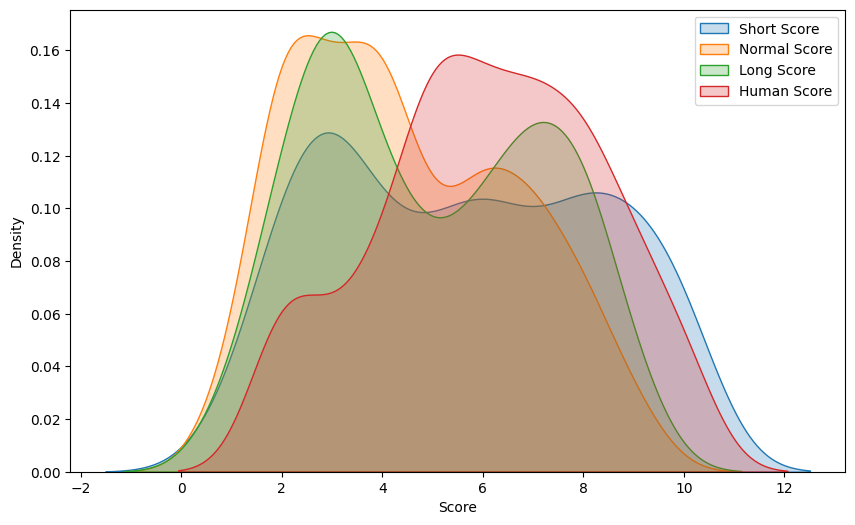

In [72]:
import seaborn as sns

import matplotlib.pyplot as plt

# 绘制 KDE 图
plt.figure(figsize=(10, 6))
sns.kdeplot(df['short_score'], label='Short Score', shade=True)
sns.kdeplot(df['normal_score'], label='Normal Score', shade=True)
sns.kdeplot(df['long_score'], label='Long Score', shade=True)
sns.kdeplot(df['Human'], label='Human Score', shade=True)

# 添加标题和标签
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()

# 显示图形
plt.show()

In [5]:
from src.consistency import  calculate_correlation
# print(calculate_correlation(df['short_score'], df['normal_score']))
# print(calculate_correlation(df['short_score'], df['long_score']))
# print(calculate_correlation(df['normal_score'], df['long_score']))
print('spearman, short vs human:', calculate_correlation(df['short_score'], df['Human']))
print('spearman, normal vs human:', calculate_correlation(df['normal_score'], df['Human']))
print('spearman, long vs human:', calculate_correlation(df['long_score'], df['Human']))

print('kendall:', calculate_correlation(df['short_score'], df['Human'],'t'))
print('kendall:', calculate_correlation(df['normal_score'], df['Human'],'t'))
print('kendall:', calculate_correlation(df['long_score'], df['Human'],'t'))

spearman, short vs human: 45.36572793978562
spearman, normal vs human: 42.364714135188
spearman, long vs human: 36.12349858417613
kendall: 35.159879037285236
kendall: 32.943393308593315
kendall: 27.65181809352099


In [7]:
df.columns

Index(['ambiguous_question', 'qa_pairs', 'wikipages', 'annotations',
       'sample_id', 'response', 'answers', 'answer_length', 'long_answers',
       'short_answers', 'long_answer_length', 'short_answer_length',
       'response_length', 'answer_relevance_prompt',
       'answers_relevance_completion', 'answers_relevance_res',
       'response_with_ref_prompt', 'response_with_ref_completion',
       'response_with_ref_score', 'Rouge L', 'Exact Match', 'Disambig F1',
       'BERT Score', 'GPT-4o Accuracy', 'GPT-4o Informativeness',
       'Answer Relevance', 'Human Accuracy', 'Human Informativeness', 'model',
       'GPT-4o Fine-grained', 'Human', 'Claude-3.5', 'Gemini-2.0', 'GPT-4o',
       'short_score', 'normal_score', 'long_score'],
      dtype='object')

In [8]:
print(calculate_correlation(df['short_score'], df['normal_score']))
print(calculate_correlation(df['short_score'], df['long_score']))
print(calculate_correlation(df['normal_score'], df['long_score']))
print(calculate_correlation(df['long_score'], df['GPT-4o Fine-grained']))
print(calculate_correlation(df['normal_score'], df['GPT-4o']))

85.91078253388837
78.43954713610246
86.97798548851894
66.2492725100715
85.19582746739589


In [73]:
# 计算三种评分和human评分之间的皮尔逊相关系数
short_human_corr = df['short_score'].corr(df['Human'])
normal_human_corr = df['normal_score'].corr(df['Human'])
long_human_corr = df['long_score'].corr(df['Human'])

print(f"Short Score and Human Score Correlation: {short_human_corr}")
print(f"Normal Score and Human Score Correlation: {normal_human_corr}")
print(f"Long Score and Human Score Correlation: {long_human_corr}")

Short Score and Human Score Correlation: 0.4452183028606176
Normal Score and Human Score Correlation: 0.4112810013267943
Long Score and Human Score Correlation: 0.3650462501357422
